# Linear classification with rate constraints.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_gaussian_mixture.ipynb)


:::{note}
This example highlights the use of proxy constraints {cite:t}`cotter2019JMLR`. Proxy
constraints allow using different constraint violations for updating the primal and
dual variables. They are useful when the true constraint is non-differentiable, but
there exists a differentiable surrogate that is aligned with the original constraint.
This example is based on Fig. 2 of {cite:t}`cotter2019JMLR`.

By default, Cooper uses the provided violation to update both the primal and dual.
To use proxy constraints, the user must provide a `strict_violation` in the
`ConstraintState` object. The `strict_violation` is used to update the dual variables,
while the `violation` is used to update the primal variables.
:::

In this example we consider a linear classification problem on a synthetically generated
mixture of Gaussians. We constrain the model to predict at least 70% of the training
points as class blue (class 0). The optimization problem is defined as follows:

$$
min_{w, b} \mathbb{E}_{(x, y) \sim \mathcal{D}} \left[ \ell(w^T x + b, y) \right] s.t. \mathbb{E}_{(x, y) \sim \mathcal{D}} \mathbb{1}_{\sigma(w^T x + b) \leq 0} \geq 0.7
$$

where $\ell$ is the binary cross-entropy loss, $w$ and $b$ are the
weights and bias of the linear model, and $x$ and $y$ are the input and
target labels. The expectation is computed over the data distribution
$\mathcal{D}$.

Note that this constraint is not continuous on the model parameters, and so it is not
differentiable. The typical Lagrangian approach is not applicable in this setting as
we can not compute the derivatives of the constraint.

A possible approach to deal with this difficulty is to retain the Lagrangian
formulation, but replace the constraints with differentiable approximations or
surrogates. However, changing the constraint functions can result in an over- or
under-constrained version of the problem (as illustrated in this tutorial).

{cite:t}`cotter2019JMLR` propose a *proxy-Lagrangian formulation*, in which the
non-differentiable constraints are relaxed *only when necessary*. In other
words, the non-differentiable constraint functions are used to compute the
Lagrangian and constraint violations (and thus the to update the Lagrange multipliers),
while the surrogates are used to compute gradients of the Lagrangian with
respect to the parameters of the model.

**Surrogate.** The surrogate considered in this tutorial is the following:

$$
P(\hat{y}=0) \geq 0.7
$$

where $P(\hat{y}=0) = \mathbb{E}_{(x, y) \sim \mathcal{D}} P(\hat{y}=0 | x) = \mathbb{E}_{(x, y) \sim \mathcal{D}} 1 - \sigma(w^T x + b)$
is the proportion of points predicted as class 0 by the model.

Note that the surrogate is differentiable with respect to the model parameters, and it
is aligned with the original constraint: an increase in the probability of predicting
class 0 leads to an increase in the proportion of points predicted as class 0.

**Results.** The plot shows the decision boundary of the linear model trained with
three different formulations: unconstrained, constrained with the surrogate constraint,
and constrained with proxy constraints.

* The proportion of points predicted as class 0 when training without constraints is
50%. This is to be expected, as the model is optimizing the loss over a balanced and
(almost) separable dataset.
* The middle plot shows the decision boundary of the model trained with the surrogate
constraint. The proportion of points predicted as class 0 is 66%, which is below the
desired 70%. This is due to the relaxation of the constraint, which is different
from the original constraint.
* The rightmost plot shows the decision boundary of the model trained with the proxy
constraint. The proportion of points predicted as class 0 is 70%, thus yielding a
feasible solution.

In [1]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

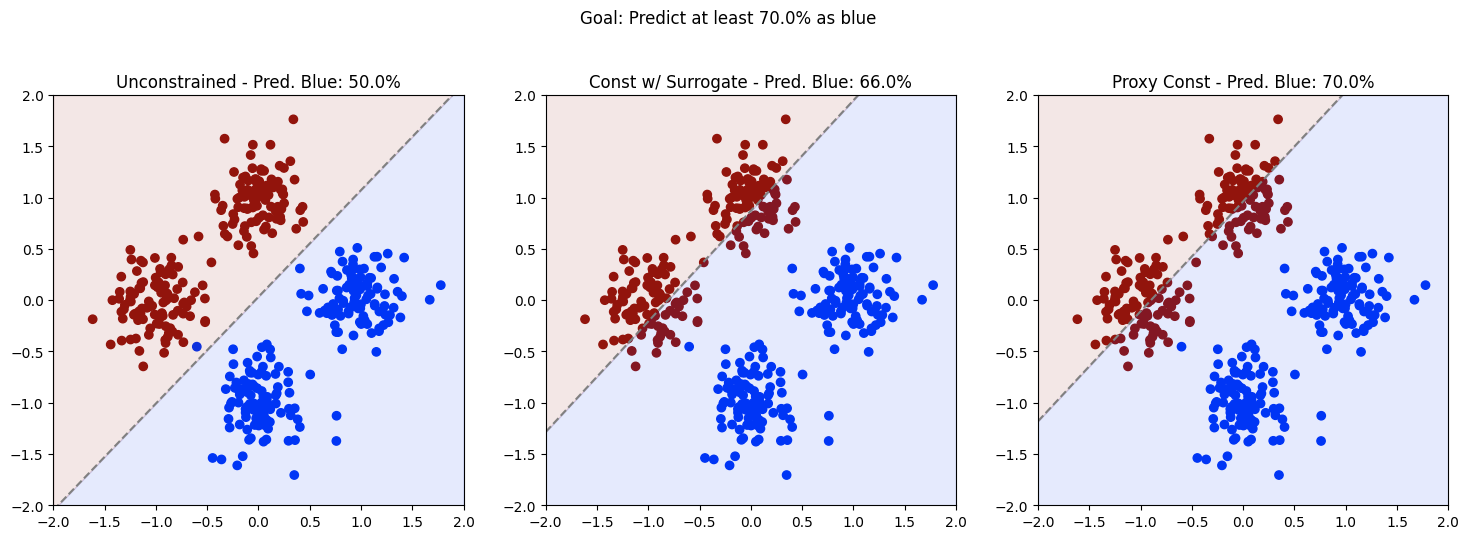

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

import cooper

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


def generate_mog_dataset():
    """Generate a MoG dataset on 2D, with two classes."""
    n_samples_per_class = 100
    dim = 2
    n_gaussians = 4
    means = [(0, 1), (-1, 0), (0, -1), (1, 0)]
    means = [torch.tensor(m) for m in means]
    var = 0.05

    inputs, labels = [], []

    for idx in range(n_gaussians):
        # Generate input data by mu + x @ sqrt(cov)
        cov = np.sqrt(var) * torch.eye(dim)  # Diagonal covariance matrix
        mu = means[idx]
        inputs.append(mu + torch.randn(n_samples_per_class, dim) @ cov)

        # Labels
        labels.append(torch.tensor(n_samples_per_class * [1.0 if idx < 2 else 0.0]))

    return torch.cat(inputs, dim=0), torch.cat(labels, dim=0)


def plot_pane(ax, inputs, x1, x2, achieved_const, titles, colors):
    const_str = str(np.round(achieved_const, 0)) + "%"
    ax.scatter(*torch.transpose(inputs, 0, 1), color=colors)
    ax.plot(x1, x2, color="gray", linestyle="--")
    ax.fill_between(x1, -2, x2, color=blue, alpha=0.1)
    ax.fill_between(x1, x2, 2, color=red, alpha=0.1)

    ax.set_aspect("equal")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(titles[idx] + " - Pred. Blue: " + const_str)


class UnconstrainedMixtureSeparation(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        super().__init__()

    def compute_cmp_state(self, model, inputs, targets):
        logits = model(inputs)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.flatten(), targets)
        return cooper.CMPState(loss=loss)


class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    """Implements CMP for separating the MoG dataset with a linear predictor.

    Args:
        use_strict_constraints: Flag to use proxy-constraints. If ``False``, we use a
            hinge relaxation both for updating the Lagrange multipliers and for updating
            the model parameters. If ``True``, we use the hinge relaxation only for the
            model parameters, and the true rate of blue predictions for updating the
            Lagrange multipliers. Defaults to ``False``.
        constraint_level: Minimum proportion of points to be predicted as belonging to
            the blue class. Ignored when ``is_constrained==False``. Defaults to ``0.7``.
    """

    def __init__(self, use_strict_constraints: bool = False, constraint_level: float = 0.7):
        super().__init__()

        constraint_type = cooper.ConstraintType.INEQUALITY
        multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1)
        self.rate_constraint = cooper.Constraint(
            constraint_type=constraint_type, formulation_type=cooper.LagrangianFormulation, multiplier=multiplier
        )

        self.constraint_level = constraint_level
        self.use_strict_constraints = use_strict_constraints

    def compute_cmp_state(self, model, inputs, targets):
        logits = model(inputs)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits.flatten(), targets)

        # Hinge approximation of the rate
        probs = torch.sigmoid(logits)

        # Surrogate "constraint": prob_0 >= constraint_level -> constraint_level - prob_0 <= 0
        differentiable_violation = self.constraint_level - torch.mean(1 - probs)

        if self.use_strict_constraints:
            # Use the true rate of blue predictions as the constraint
            classes = logits >= 0.0
            prop_0 = torch.sum(classes == 0) / targets.numel()

            # Constraint: prop_0 >= constraint_level -> constraint_level - prop_0 <= 0
            strict_violation = self.constraint_level - prop_0

            constraint_state = cooper.ConstraintState(
                violation=differentiable_violation, strict_violation=strict_violation
            )
        else:
            constraint_state = cooper.ConstraintState(violation=differentiable_violation)

        return cooper.CMPState(loss=loss, observed_constraints={self.rate_constraint: constraint_state})


def train(problem_name, inputs, targets, num_iters=5000, lr=1e-2, constraint_level=0.7):
    is_constrained = "unconstrained" not in problem_name.lower()
    use_strict_constraints = "proxy" in problem_name.lower()

    model = torch.nn.Linear(2, 1)
    primal_optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)

    if is_constrained:
        cmp = MixtureSeparation(use_strict_constraints, constraint_level)
        dual_optimizer = torch.optim.SGD(cmp.dual_parameters(), lr=lr, momentum=0.7, maximize=True)
        cooper_optimizer = cooper.optim.SimultaneousOptimizer(
            primal_optimizers=primal_optimizer, dual_optimizers=dual_optimizer, cmp=cmp
        )
    else:
        cmp = UnconstrainedMixtureSeparation()
        cooper_optimizer = cooper.optim.UnconstrainedOptimizer(primal_optimizers=primal_optimizer, cmp=cmp)

    for _ in range(num_iters):
        cooper_optimizer.roll(compute_cmp_state_kwargs={"model": model, "inputs": inputs, "targets": targets})

    # Number of elements predicted as class 0 in the train set after training
    logits = model(inputs)
    pred_classes = logits >= 0.0
    prop_0 = torch.sum(pred_classes == 0) / targets.numel()

    return model, 100 * prop_0.item()


# Plot configs
titles = ["Unconstrained", "Const w/ Surrogate", "Proxy Const"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Data and training configs
inputs, labels = generate_mog_dataset()
constraint_level = 0.7
lr = 2e-2
num_iters = 5000

for idx, name in enumerate(titles):
    model, achieved_const = train(name, inputs, labels, lr=lr, num_iters=num_iters, constraint_level=constraint_level)

    # Compute decision boundary
    weight, bias = model.weight.data.flatten().numpy(), model.bias.data.numpy()
    x1 = np.linspace(-2, 2, 100)
    x2 = (-1 / weight[1]) * (weight[0] * x1 + bias)

    # Color points according to true label
    red, blue = "#92140C", "#0035f5"
    colors = [red if _ == 1 else blue for _ in labels.flatten()]
    plot_pane(axs[idx], inputs, x1, x2, achieved_const, titles, colors)

fig.suptitle("Goal: Predict at least " + str(constraint_level * 100) + "% as blue")
plt.show()